In [1]:
import os
import cv2
import numpy as np
from tqdm import tqdm

In [ ]:
REBUILD_DATA = False

class DogsVSCats():
    IMG_SIZE = 50
    CATS = 'PetImages/Cat'
    DOGS = 'PetImages/Dog'
    LABELS = { CATS: 0, DOGS: 1 }
    training_data = []
    cat_count = 0
    dog_count = 0

    def make_training_data(self):
        for label in self.LABELS:
            print(label)
            for i in tqdm(os.listdir(label)):
                try:
                    path = os.path.join(label, i)
                    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
                    img = cv2.resize(img, (self.IMG_SIZE, self.IMG_SIZE))
                    self.training_data.append([
                        np.array(img), 
                        np.eye(2)[self.LABELS[label]]
                    ])

                    if label == self.CATS:
                        self.cat_count += 1
                    elif label == self.DOGS:
                        self.dog_count += 1
                except Exception as e:
                    pass
                    #print(str(e))

        np.random.shuffle(self.training_data)
        np.save('training_data.npy', self.training_data)
        print('Cats:', self.cat_count)
        print('Dogs:', self.dog_count)

if REBUILD_DATA:
    dogsvcats = DogsVSCats()
    dogsvcats.make_training_data()

In [2]:
training_data = np.load('training_data.npy', allow_pickle=True)
print(len(training_data))

24946


In [ ]:
import matplotlib.pyplot as plt

plt.imshow(training_data[1][0], cmap='gray')

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, 5)
        self.conv2 = nn.Conv2d(32, 64, 5)
        self.conv3 = nn.Conv2d(64, 128, 5)

        x = torch.randn(50, 50).view(-1, 1, 50, 50)
        self._to_linear = None
        self.convs(x)

        self.fc1 = nn.Linear(self._to_linear, 512)
        self.fc2 = nn.Linear(512, 2)

    def convs(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        x = F.max_pool2d(F.relu(self.conv2(x)), (2, 2))
        x = F.max_pool2d(F.relu(self.conv3(x)), (2, 2))

        print(x[0].shape)

        if self._to_linear is None:
            self._to_linear = x[0].shape[0] * x[0].shape[1] * x[0].shape[2]
        return x

    def forward(self, x):
        x = self.convs(x)
        x = x.view(-1, self._to_linear)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.softmax(x, dim=1)

net = Net()

torch.Size([128, 2, 2])


In [4]:
device = torch.device('cuda:0')
net = Net().to(device)
device

torch.Size([128, 2, 2])


device(type='cuda', index=0)

In [5]:
import torch.optim as optim

optimizer = optim.Adam(net.parameters(), lr=0.001)
loss_function = nn.MSELoss()

x = torch.Tensor([i[0] for i in training_data]).view(-1, 50, 50)
x = x/255.0
y = torch.Tensor([i[1] for i in training_data])

VAL_PCT = 0.1
val_size = int(len(x) * VAL_PCT)
print(val_size)

train_x = x[:-val_size]
train_y = y[:-val_size]

test_x = x[-val_size:]
test_y = y[-val_size:]

print(len(train_x))
print(len(test_x))

2494
22452
2494


In [11]:
def fwd_pass(x, y, train=False):
    if train:
        net.zero_grad()
    outputs = net(x)
    matches = [torch.argmax(i) == torch.argmax(t) for i, t in zip(outputs, y)]
    accuracy = matches.count(True) / len(matches)
    loss = loss_function(outputs, y)

    if train:
        loss.backward()
        optimizer.step()
    return accuracy, loss

In [13]:
def test(size=32):
    random_start = np.random.randint(len(test_x) - size)
    x, y = test_x[random_start:random_start + size], test_y[random_start:random_start + size]
    with torch.no_grad():
        val_acc, val_loss = fwd_pass(x.view(-1, 1, 50, 50).to(device), y.to(device))
    return val_acc, val_loss

val_acc, val_loss = test(size=32)
print(val_acc, val_loss)

torch.Size([128, 2, 2])
0.53125 tensor(0.2487, device='cuda:0')


In [14]:
import time

MODEL_NAME = f'model - {int(time.time())}'

net = Net().to(device)
optimizer = optim.Adam(net.parameters(), lr=0.001)
loss_function = nn.MSELoss()

print(MODEL_NAME)

def train():
    BATCH_SIZE = 100
    EPOCHS = 8

    with open('model.log', 'a') as f:
        for epoch in range(EPOCHS):
            for i in tqdm(range(0, len(train_x), BATCH_SIZE)):
                batch_x = train_x[i:i + BATCH_SIZE].view(-1, 1, 50, 50).to(device)
                batch_y = train_y[i:i + BATCH_SIZE].to(device)

                accuracy, loss = fwd_pass(batch_x, batch_y, train=True)
                if i % 50 == 0:
                    val_acc, val_loss = test(size=100)
                    f.write(f'{MODEL_NAME}, {round(time.time(), 3)}, {round(float(accuracy), 2)}, {round(float(loss), 4)},  {round(float(val_acc), 2)}, {round(float(val_loss), 4)}\n')

train()


torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
 74%|███████▍  | 167/225 [00:17<00:06,  9.16it/s]torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
 75%|███████▌  | 169/225 [00:17<00:06,  9.30it/s]torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
 76%|███████▋  | 172/225 [00:18<00:05,  9.15it/s]torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
 77%|███████▋  | 174/225 [00:18<00:05,  9.21it/s]torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
 79%|███████▊  | 177/225 [00:18<00:05,  9.16it/s]torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
 79%|███████▉  | 178/225 [00:18<00:05,  8.85it/s]torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
 80%|████████  | 180/225 [00:19<00:05,  8.79it/s]torch.Si

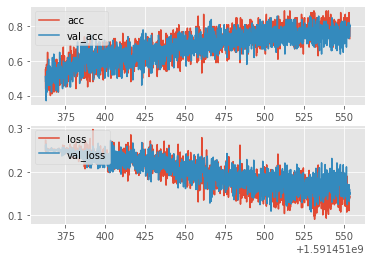

In [23]:
import matplotlib.pyplot as plt
from matplotlib import style

style.use('ggplot')

model_name= 'model - 1591451362'

def create_acc_loss_graph(model_name):
    contents = open('model.log', 'r').read().split('\n')

    times = []
    accuracies = []
    losses = []

    val_accs = []
    val_losses = []

    for content in contents:
        if model_name in content:
            name, timestamp, accuracy, loss, val_acc, val_loss = content.split(',')

            times.append(float(timestamp))
            accuracies.append(float(accuracy))
            losses.append(float(loss))

            val_accs.append(float(val_acc))
            val_losses.append(float(val_loss))

    fig = plt.figure()

    axis1 = plt.subplot2grid((2, 1), (0, 0))
    axis2 = plt.subplot2grid((2, 1), (1, 0), sharex=axis1)

    axis1.plot(times, accuracies, label='acc')
    axis1.plot(times, val_accs, label='val_acc')
    axis1.legend(loc=2)

    axis2.plot(times, losses, label='loss')
    axis2.plot(times, val_losses, label='val_loss')
    axis2.legend(loc=2)

create_acc_loss_graph(model_name)

In [24]:
torch.save(net.state_dict(), 'catvsdog_model.pt')

In [26]:
model = Net()
model.load_state_dict(torch.load('catvsdog_model.pt'))
model.eval()

torch.Size([128, 2, 2])


Net(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=512, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=2, bias=True)
)

torch.Size([128, 2, 2])


1

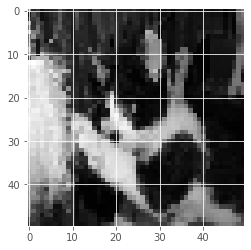

In [94]:
def predict_image(image):
    plt.imshow(image, cmap='gray')
    a = torch.Tensor([image])
    output = model(a.view(-1, 1, 50, 50))
    index = output.data.numpy().argmax()
    return index

predict_image(training_data[15][0])
# Gives me random bullshit results :/